In [1]:
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
pd.options.mode.copy_on_write = True 

ref_data_dir = "Tartarus/datasets"
cal_data_dir = "RESULTS/"
datasets = ["organic_emitter", "docking", "reactivity"]
target_columns_dict = {"organic_emitter": ["singlet-triplet value", "oscillator strength", "abs_diff_vee"], 
                       "docking": ["1syh score", "4lde score", "6y2f score"], 
                       "reactivity": ["activation_energy", "reaction_energy"]}
data_name_dict = {"organic_emitter": "gdb13.csv", "docking":"docking.csv", "reactivity":"reactivity.csv"}
title_rename_dict = {"activation_energy": "Activation energy", "reaction_energy": "Reaction energy",
                     "1syh score": "1syh score", "4lde score": "4lde score", "6y2f score": "6y2f score",
                     "singlet-triplet value": "Singlet-triplet value", "oscillator strength": "Oscillator strength",
                     "abs_diff_vee": "Absolute difference of\nvertical excitation energy"}

In [2]:
def update_dataframe(df, data_dict, target_columns):
    all_values = []
    for smiles in df["smiles"]:
        values = data_dict.get(smiles)
        if (values == None) or (abs(values[0]) == 10000):
            values = float("nan")
        all_values.append(values)
    df["all_targets"] = all_values
    df = df.dropna()
    for i, target in enumerate(target_columns):
        sub_target_list = list(list(zip(*df["all_targets"]))[i])
        df[target+"_reproduced"] = sub_target_list
    del df["all_targets"]
    return df



0.8780561897449091
0.7963502898883341
0.8578855862990712
0.8988358127250524
0.8639092287509551
0.9599582804911309
0.6516064871343612
0.9189884153903705


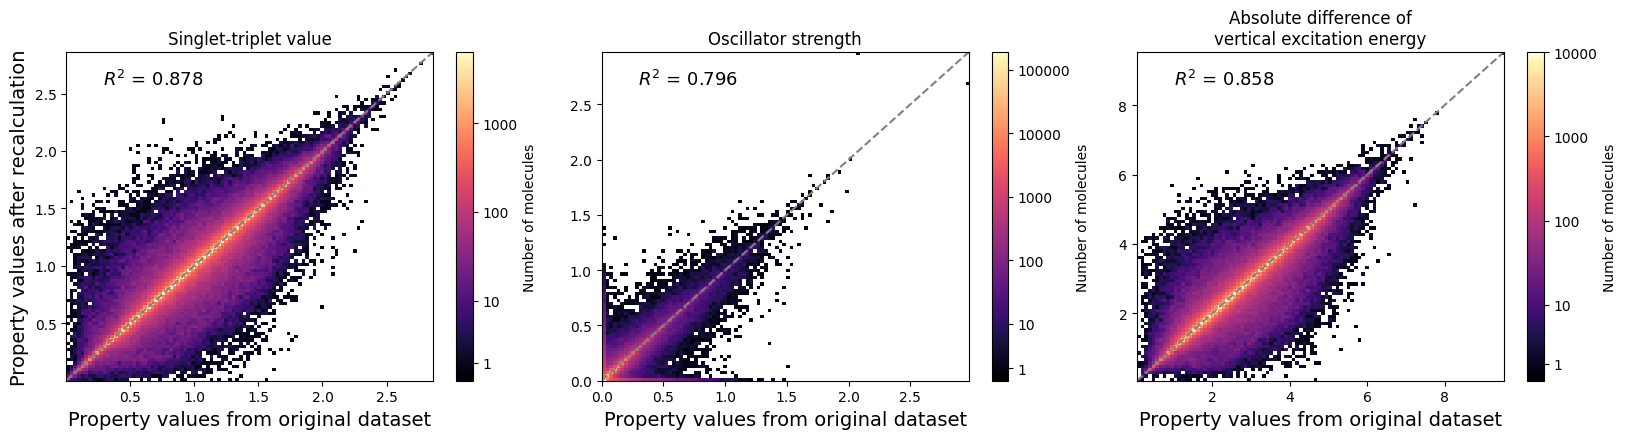

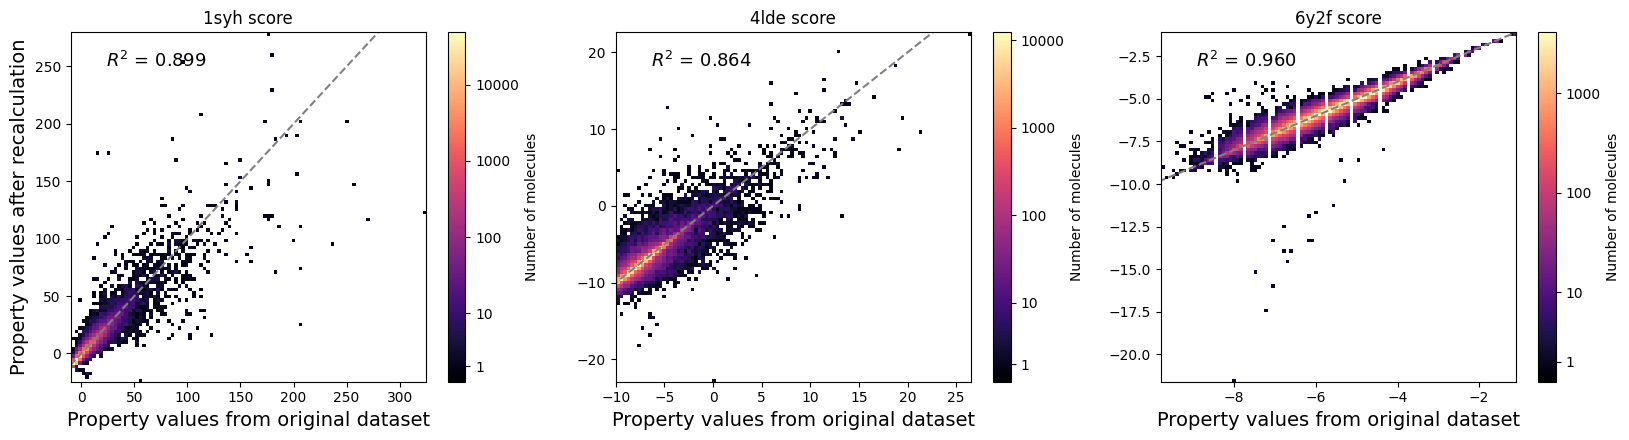

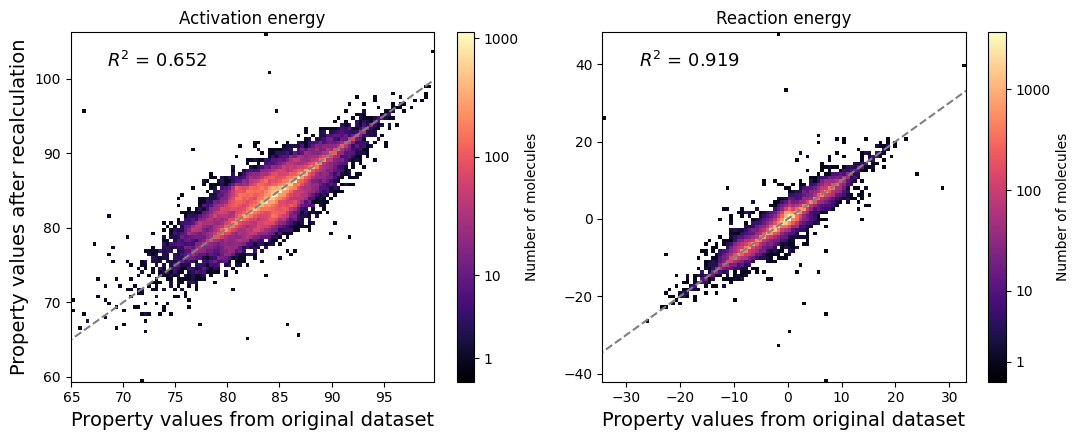

In [4]:
os.makedirs(f"figures/reproduce_parity", exist_ok=True)

for dataset in datasets:
    target_columns = target_columns_dict[dataset]
    if dataset == "reactivity":
        ref_data = pd.read_csv(os.path.join(ref_data_dir, data_name_dict[dataset]))[["smiles_stereo"] + target_columns]
        ref_data = ref_data.rename(columns={"smiles_stereo": "smiles"})
    else:
        ref_data = pd.read_csv(os.path.join(ref_data_dir, data_name_dict[dataset]))[["smiles"] + target_columns]

    with open(os.path.join(cal_data_dir, f"{dataset}_all/cal_dict.pkl"), "rb") as f:
        cal_data = pickle.load(f)
    ref_data = update_dataframe(ref_data, cal_data, target_columns)

    num_targets = len(target_columns)
    plt.figure(figsize=(5.5*num_targets, 4.5), dpi=100)
    index = int("1"+str(num_targets)+"1")
    for j, target in enumerate(target_columns):
        target_rep = target + "_reproduced"
        # draw the plot
        min_point = min(min(ref_data[target]), min(ref_data[target_rep]))
        max_point = max(max(ref_data[target]), max(ref_data[target_rep]))
        points = np.linspace(min_point,max_point,20)
        rmse = np.sqrt(mean_squared_error(ref_data[target], ref_data[target_rep]))
        r2 = r2_score(ref_data[target], ref_data[target_rep])
        print(r2)

        plt.subplot(index+j)
        plt.plot(points, points, color='gray', linestyle='--')
        # sns.scatterplot(data=ref_data, x=target, y=target_rep,)
        # plt.scatter(ref_data[target], ref_data[target_rep], alpha=0.15, c="black", s=7)
        num_bins = 100
        counts, xedges, yedges = np.histogram2d(ref_data[target], ref_data[target_rep], bins=num_bins)
        log_counts = np.log10(counts + 1) ###

        cmap = sns.color_palette("magma", as_cmap=True)
        cmap.set_under(color='white')
        plt.imshow(log_counts.T, origin='lower', cmap=cmap, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', vmin=0.1)
        cbar = plt.colorbar(label='Number of molecules')
        if target in ["abs_diff_vee", "1syh score", "4lde score"]:
            cbar.set_ticks([0.3, 1, 2, 3, 4])  # Set ticks for log scale
            cbar.set_ticklabels(['1', '10', '100', '1000', '10000'])  # Set tick labels for log scale
        elif target == "oscillator strength":
            cbar.set_ticks([0.3, 1, 2, 3, 4, 5])  # Set ticks for log scale
            cbar.set_ticklabels(['1', '10', '100', '1000', '10000', '100000'])
        else:
            cbar.set_ticks([0.3, 1, 2, 3])  # Set ticks for log scale
            cbar.set_ticklabels(['1', '10', '100', '1000']) 


        plt.xlabel('Property values from original dataset', fontsize=14)
        if j == 0:
            plt.ylabel('Property values after recalculation', fontsize=14)
        else:
            plt.ylabel("")
        plt.title(title_rename_dict[target])
        plt.text(0.1, 0.9, r'$R^2$ = ' + f'{r2:.3f}', transform=plt.gca().transAxes, fontsize=13)
    plt.tight_layout()
    plt.savefig(f"figures/reproduce_parity/{dataset}.svg", format="svg")